In [1]:
#!pip install nes_py
#!pip install torch
#!pip install -U matplotlib
#!pip install scikit-image

In [2]:
from nes_py.wrappers import JoypadSpace
from nes_py import NESEnv
from time import sleep

env = NESEnv('./ROMs/Final_Fantasy.nes')
env = JoypadSpace(env, [['up'], ['down'], ['left'], ['right'], ['A'], ['B'], ['start'], ['select']])

In [3]:
# print len of joypad space
env.action_space.n

8

In [4]:
# Preprocessing
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

def preprocess_frame(frame, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(frame, new_size, anti_aliasing=True).max(axis=2)
    else:
        return resize(frame, new_size, anti_aliasing=True)

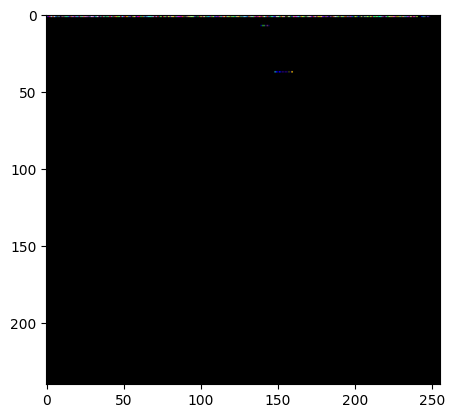

In [5]:
plt.imshow(env.render(mode='rgb_array'))

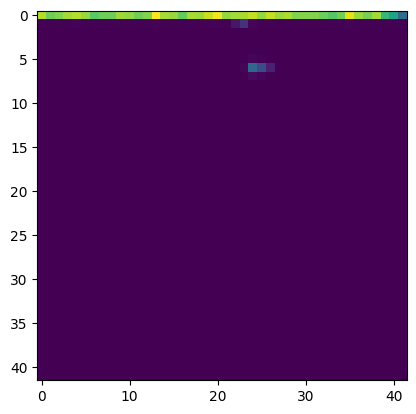

In [7]:
plt.imshow(preprocess_frame(env.render(mode='rgb_array'), to_gray=True))

In [29]:
# Each state given to the agent is a concatenation of the last 4 frames 
import torch
from collections import deque
from torch import nn
from torch import optim
import torch.nn.functional as F

def prepare_state(state):
    return torch.from_numpy(preprocess_frame(state, to_gray=True)).float().unsqueeze(0)

def prepare_multi_states(state1, state2):
    state1 = state1.clone()
    temp = torch.from_numpy(preprocess_frame(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = temp
    return state1

def prepare_initial_state(state, N=3):
    state_ = torch.from_numpy(preprocess_frame(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(0)

In [30]:
# Policy definition

def policy(qvalues, eps=None):
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0, high=qvalues.shape[1], size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)

In [31]:
# Experience replay memory in order to sample mini batches of experiences for training
from random import shuffle

class ExperienceReplayMemory:
    def __init__(self, N=500, batch_size=100):
        self.N = N
        self.batch_size = batch_size
        self.memory = []
        self.counter = 0

    def add_memory(self, state1, action, reward, state2):
        self.counter += 1
        if self.counter % self.N == 0:
            self.shuffle_memory()
        if(len(self.memory) < self.N):
            self.memory.append((state1, action, reward, state2))
        else:
            rand_idx = np.random.randint(0, self.N - 1)
            self.memory[rand_idx] = (state1, action, reward, state2)

    def shuffle_memory(self):
        shuffle(self.memory)

    def get_batch(self):
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: Memory is empty")
            return None
        
        ind = np.random.choice(np.arange(len(self.memory)), batch_size, replace=False)
        batch = [self.memory[i] for i in ind]
        state1_batch = torch.stack([x[0].squeeze(0) for x in batch], dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(0) for x in batch], dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch


In [53]:
# Intrinsic curiosity module: 3 diverse nn networks (forward, inverse, encoder)

class Phi(nn.Module): # Encoder
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    
    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=1)
        return y
    
class Gnet(nn.Module): # Inverse model
    def __init__(self):
        super(Gnet, self).__init__()
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 8)

    def forward(self, state1, state2):
        x = torch.cat((state1, state2), dim=1)
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        y = F.softmax(y, dim=1)
        return y
    
class Fnet(nn.Module): # Forward model
    def __init__(self):
        super(Fnet, self).__init__()
        self.fc1 = nn.Linear(300, 256)
        self.fc2 = nn.Linear(256, 288)

    def forward(self, state, action):
        print(action.shape)
        action_ = torch.zeros((action.shape[0], 8))
        indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1
        print(action_.shape)
        x = torch.cat((state, action_), dim=1)
        print(state.shape)
        print(x.shape)
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return y

In [54]:
# Q network

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.fc1 = nn.Linear(288, 100)
        self.fc2 = nn.Linear(100, 8)

    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.fc1(y))
        y = self.fc2(y)
        return y

In [55]:
# hyperparameters
hyperparams = {
    'batch_size': 150,
    'beta': 0.2,
    'lambda': 0.1,
    'eta': 1.0,
    'gamma': 0.2,
    'max_episode_length': 100,
    'min_progress': 15,
    'action_repeats': 6,
    'frames_per_state': 3
}

In [56]:
replay = ExperienceReplayMemory(N=1000, batch_size=hyperparams['batch_size'])
qnet = Qnet()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(qnet.parameters()) + list(encoder.parameters()) + list(forward_model.parameters()) + list(inverse_model.parameters())
optimizer = optim.Adam(all_model_params, lr=0.001)

In [57]:
def loss_fn(q_loss, forward_loss, inverse_loss):
    loss_ = (1 - hyperparams['beta'])*inverse_loss
    loss_ += hyperparams['beta']*forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss_ += hyperparams['lambda']*q_loss
    return loss_

def reset_env():
    env.reset()
    state1 = prepare_initial_state(env.render(mode='rgb_array'))
    return state1

In [58]:
def ICM(state1, action, state2, forward_scale = 1., inverse_scale = 1e4):
    state1_hat = encoder(state1)
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach())
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat)
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

def minibatch_train(use_explicit=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1)
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch)
    i_reward = (1./hyperparams['eta'])*forward_pred_err 
    reward = i_reward.detach() 
    if use_explicit:
        reward += reward_batch
    qvals = qnet(state2_batch)
    reward += hyperparams['gamma']*torch.max(qvals)
    reward_pred = qnet(state1_batch) 
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

In [59]:
epochs = 3500
env.reset()
state1 = prepare_initial_state(env.render(mode='rgb_array'))
eps = 0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=hyperparams['frames_per_state'])
e_reward = 0
ep_lengths = []
use_explicit = False
for i in range(epochs):
    optimizer.zero_grad()
    episode_length += 1
    q_val_pred = qnet(state1)
    if i > switch_to_eps_greedy:
        action = int(policy(q_val_pred, eps))
    else:
        action = int(policy(q_val_pred))
    for j in range(hyperparams['action_repeats']):
        state2, e_reward_, done, info = env.step(action)
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque), dim=1)
    replay.add_memory(state1, action, e_reward, state2)
    e_reward = 0
    if episode_length > hyperparams['max_episode_length']:
        done = True
    if done:
        ep_lengths.append(episode_length)
        episode_length = 0
        state1 = reset_env()
    else:
        state1 = state2
    if len(replay.memory) < hyperparams['batch_size']:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_explicit=use_explicit)
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err)
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(), inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    loss.backward()
    optimizer.step()

# Plot losses
losses_ = np.array(losses)
plt.figure(figsize=(8,6))
plt.plot(np.log(losses_[:,0]), label='Q loss')
plt.plot(np.log(losses_[:,1]), label='Forward loss')
plt.plot(np.log(losses_[:,2]), label='Inverse loss')
plt.legend()
plt.show()

C:\Users\UTENTE\AppData\Local\Temp\ipykernel_15016\3355323674.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)


torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])
torch.Size([150, 12])
torch.Size([150, 288])
torch.Size([150, 300])
torch.Size([150, 1])


KeyboardInterrupt: 